In [1]:
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools, Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem

In [3]:
from xgboost import XGBRegressor

In [4]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, LinearRegression

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error

In [6]:
import matplotlib.pyplot as plt

In [7]:
from rdkit.Chem import Descriptors

In [8]:
from rdkit import __version__

In [9]:
print(__version__)

2023.09.6


In [10]:
full = ['PI_COUNT',
 'NI_COUNT',
 'AR_COUNT',
 'H_COUNT',
 'HBD_COUNT',
 'HBA_COUNT',
 'XBD_COUNT',
 'XBA_COUNT',
 'HVY_ATOM_COUNT',
 'ROT_BOND_COUNT',
 'TOTAL_HYD',
 'LOGP',
 'TPSA',
 'ENV_HBA_OCC_SUM',
 'ENV_HBA_OCC_MAX',
 'ENV_HBD_OCC_SUM',
 'ENV_HBD_OCC_MAX',
 'PI_AR_SCORE_SUM',
 'PI_AR_SCORE_MAX',
 'AR_PI_SCORE_SUM',
 'AR_PI_SCORE_MAX',
 'H_H_SCORE_SUM',
 'H_H_SCORE_MAX',
 'AR_AR_SCORE_SUM',
 'AR_AR_SCORE_MAX',
 'HBD_HBA_SCORE_SUM',
 'HBD_HBA_SCORE_MAX',
 'HBA_HBD_SCORE_SUM',
 'HBA_HBD_SCORE_MAX',
 'XBD_XBA_SCORE_SUM',
 'XBD_XBA_SCORE_MAX',
 'ES_ENERGY',
 'ES_ENERGY_SQRD_DIST',
 'VDW_ENERGY_ATT',
 'VDW_ENERGY_REP',]

small = ['ENV_HBA_OCC_SUM',
 'ENV_HBA_OCC_MAX',
 'ENV_HBD_OCC_SUM',
 'ENV_HBD_OCC_MAX',
 'PI_AR_SCORE_SUM',
 'PI_AR_SCORE_MAX',
 'AR_PI_SCORE_SUM',
 'AR_PI_SCORE_MAX',
 'H_H_SCORE_SUM',
 'H_H_SCORE_MAX',
 'AR_AR_SCORE_SUM',
 'AR_AR_SCORE_MAX',
 'HBD_HBA_SCORE_SUM',
 'HBD_HBA_SCORE_MAX',
 'HBA_HBD_SCORE_SUM',
 'HBA_HBD_SCORE_MAX',
 'XBD_XBA_SCORE_SUM',
 'XBD_XBA_SCORE_MAX',
 'ES_ENERGY',
 'ES_ENERGY_SQRD_DIST',
 'VDW_ENERGY_ATT',
 'VDW_ENERGY_REP',]

In [64]:
df_test = PandasTools.LoadSDF('CatS/glide-dock_SP_1_zrqq_2/gc4FEset.sdf')
df_test = pd.merge(df_test, pd.read_csv('CatS/glide-dock_SP_1_zrqq_2/gc4FEset.csv'), on=df_test.index)
df_test['pIC50'] = np.log10(df_test['r_canvas_Affinity'].astype(float))*-1+6
df_test['SMILES'] = df_test.apply(lambda x: Chem.MolToSmiles(x['ROMol'], isomericSmiles=True), axis=1)
df_test = df_test.sort_values('r_i_docking_score').drop_duplicates('SMILES')

In [65]:
df_test.shape

(32, 97)

In [66]:
sum([x in df_test['SMILES'].values for x in df_train['SMILES'].values])

28

In [67]:
sum([x in df_train['SMILES'].values for x in df_test['SMILES'].values])

28

In [68]:
df_train = df_train[[x not in df_test['SMILES'].values for x in df_train['SMILES'].values]]

In [69]:
sum([x in df_test['SMILES'].values for x in df_train['SMILES'].values])

0

In [70]:
sum([x in df_train['SMILES'].values for x in df_test['SMILES'].values])

0

In [71]:
df_train.shape

(437, 98)

In [72]:
df_rdkit = pd.DataFrame([Descriptors.CalcMolDescriptors(x) for x in df_train['ROMol'].values])

In [73]:
Xrdkit = df_rdkit.values

In [74]:
Xfp = np.array([AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in df_train['ROMol'].values])
y = df_train['pIC50'].values.astype(float)

In [75]:
Xfull = np.concatenate([Xfp, df_train[full].values], axis=1)
Xsmall = np.concatenate([Xfp, df_train[small].values], axis=1)
Xofull = df_train[full].values
Xosmall = df_train[small].values
Xfprdkit = np.concatenate([Xfp, Xrdkit], axis=1)

In [76]:
r2all = dict()
maeall = dict()
y_test_all = dict()
y_pred_all = dict()
rall = dict()
Xall = dict({"Xfp":Xfp, "Xosmall":Xosmall, "Xsmall":Xsmall,"Xofull":Xofull, "Xfull":Xfull, "Xrdkit":Xrdkit, "Xfprdkit":Xfprdkit})

for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull", "Xfull", "Xrdkit", "Xfprdkit"]:
    X = Xall[Xtype]
    kf = KFold(n_splits=5, shuffle=True, random_state=171)
    r2 = []
    r = []
    mae = []
    y_pred_all1 = []
    y_test_all1 = []
    for train, test in kf.split(X):
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
    
        #clf = XGBRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
        clf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
        #clf = LinearRegression()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        r2.append(r2_score(y_test, y_pred))
        mae.append(mean_absolute_error(y_test, y_pred))
        r.append(np.corrcoef(y_pred, y_test)[0][1])
        y_test_all1.append(y_test)
        y_pred_all1.append(y_pred)
    y_test_all1 = np.hstack(y_test_all1)
    y_pred_all1 = np.hstack(y_pred_all1)
    r2all[Xtype] = r2
    maeall[Xtype] = mae
    y_test_all[Xtype] = y_test_all1
    y_pred_all[Xtype] = y_pred_all1
    rall[Xtype] = r

In [77]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    print(Xtype)
    print("R2         = %.3f +/- %.3f" % (np.mean(r2all[Xtype]), np.std(r2all[Xtype])))
    print("Peasron r  = %.3f +/- %.3f" % (np.mean(rall[Xtype]), np.std(rall[Xtype])))
    print("MAE        = %.3f +/- %.3f" % (np.mean(maeall[Xtype]), np.std(maeall[Xtype])))
    print()

Xfp
R2         = 0.657 +/- 0.080
Peasron r  = 0.815 +/- 0.054
MAE        = 0.242 +/- 0.017

Xosmall
R2         = 0.355 +/- 0.084
Peasron r  = 0.613 +/- 0.074
MAE        = 0.386 +/- 0.020

Xsmall
R2         = 0.608 +/- 0.068
Peasron r  = 0.794 +/- 0.050
MAE        = 0.285 +/- 0.015

Xofull
R2         = 0.506 +/- 0.054
Peasron r  = 0.732 +/- 0.047
MAE        = 0.330 +/- 0.014

Xfull
R2         = 0.639 +/- 0.064
Peasron r  = 0.814 +/- 0.045
MAE        = 0.271 +/- 0.015

Xrdkit
R2         = 0.665 +/- 0.068
Peasron r  = 0.820 +/- 0.044
MAE        = 0.242 +/- 0.018

Xfprdkit
R2         = 0.682 +/- 0.069
Peasron r  = 0.832 +/- 0.045
MAE        = 0.237 +/- 0.018



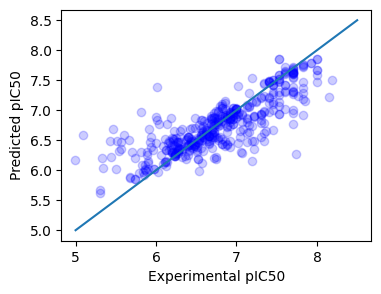

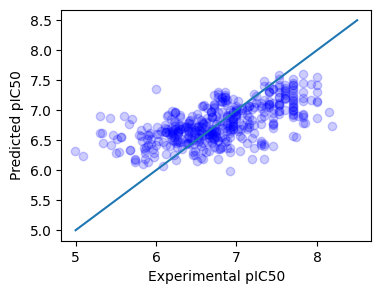

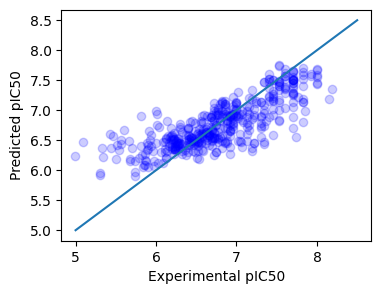

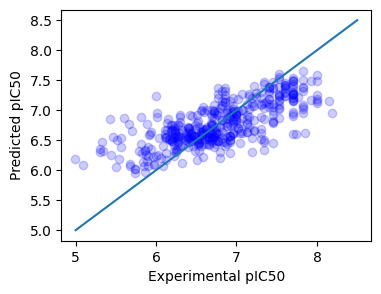

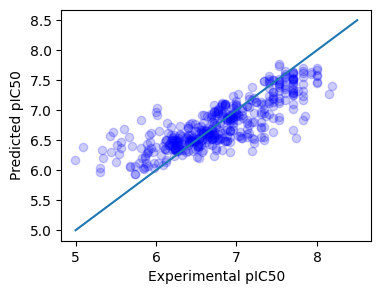

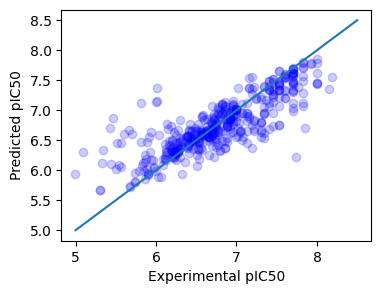

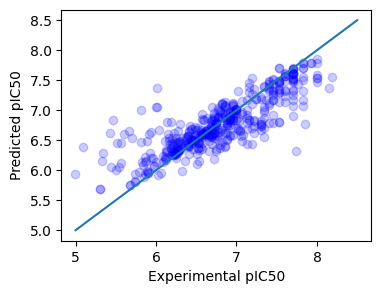

In [78]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    plt.figure(figsize=[4,3])
    plt.plot(y_test_all[Xtype], y_pred_all[Xtype], 'bo' ,alpha=.2)
    plt.plot([5,8.5],[5,8.5])
    plt.ylabel("Predicted pIC50")
    plt.xlabel("Experimental pIC50")
    plt.show()

In [79]:
Xfp_test = np.array([AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in df_test['ROMol'].values])
Xrdkit_test = pd.DataFrame([Descriptors.CalcMolDescriptors(x) for x in df_test['ROMol'].values]).values
y_test = df_test['pIC50'].values.astype(float)

Xfull_test = np.concatenate([Xfp_test, df_test[full].values], axis=1)
Xsmall_test = np.concatenate([Xfp_test, df_test[small].values], axis=1)
Xofull_test = df_test[full].values
Xosmall_test = df_test[small].values
Xfprdkit_test = np.concatenate([Xfp_test, Xrdkit_test], axis=1)

In [80]:
r2all = dict()
maeall = dict()
y_test_all = dict()
y_pred_all = dict()
impall = dict()
rall = dict()

Xall_test = dict({"Xfp":Xfp_test, "Xosmall":Xosmall_test, "Xsmall":Xsmall_test, 
                  "Xofull":Xofull_test, "Xfull":Xfull_test, "Xrdkit":Xrdkit_test, "Xfprdkit":Xfprdkit_test})

for Xtype in ["Xfp", "Xosmall", "Xsmall", "Xofull", "Xfull","Xrdkit","Xfprdkit"]:
    X_test = Xall_test[Xtype]
    X = Xall[Xtype]
    #clf = XGBRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
    clf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1)
    #clf = LinearRegression()
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    r2all[Xtype] = r2_score(y_test, y_pred)
    rall[Xtype] = np.corrcoef(y_pred, y_test)[0][1]
    maeall[Xtype] = mean_absolute_error(y_test, y_pred)
    y_test_all[Xtype] = y_test
    y_pred_all[Xtype] = y_pred
    if Xtype=='Xfp':
        imp = pd.DataFrame({"Feature":range(2048), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xosmall':
        imp = pd.DataFrame({"Feature":small, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xsmall':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048),small]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xofull':
        imp = pd.DataFrame({"Feature":full, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xfull':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048),full]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xrdkit':
        imp = pd.DataFrame({"Feature":df_rdkit.columns, "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    elif Xtype=='Xfprdkit':
        imp = pd.DataFrame({"Feature":np.hstack([range(2048), df_rdkit.columns]), "Importance":clf.feature_importances_})
        imp = imp.sort_values("Importance", ascending=False)
    impall[Xtype] = imp

In [81]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    print(Xtype)
    print("R2         = %.3f +/- %.3f" % (np.mean(r2all[Xtype]), np.std(r2all[Xtype])))
    print("Peasron r  = %.3f +/- %.3f" % (np.mean(rall[Xtype]), np.std(rall[Xtype])))
    print("MAE        = %.3f +/- %.3f" % (np.mean(maeall[Xtype]), np.std(maeall[Xtype])))
    print()

Xfp
R2         = 0.306 +/- 0.000
Peasron r  = 0.593 +/- 0.000
MAE        = 0.270 +/- 0.000

Xosmall
R2         = 0.255 +/- 0.000
Peasron r  = 0.531 +/- 0.000
MAE        = 0.293 +/- 0.000

Xsmall
R2         = 0.338 +/- 0.000
Peasron r  = 0.600 +/- 0.000
MAE        = 0.278 +/- 0.000

Xofull
R2         = 0.457 +/- 0.000
Peasron r  = 0.741 +/- 0.000
MAE        = 0.256 +/- 0.000

Xfull
R2         = 0.406 +/- 0.000
Peasron r  = 0.661 +/- 0.000
MAE        = 0.258 +/- 0.000

Xrdkit
R2         = 0.414 +/- 0.000
Peasron r  = 0.650 +/- 0.000
MAE        = 0.254 +/- 0.000

Xfprdkit
R2         = 0.420 +/- 0.000
Peasron r  = 0.653 +/- 0.000
MAE        = 0.246 +/- 0.000



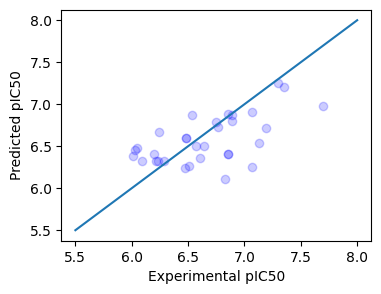

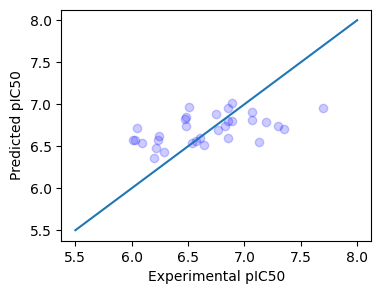

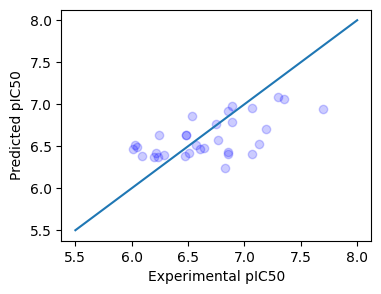

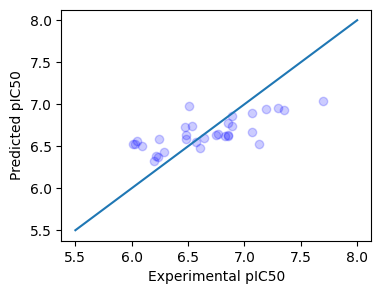

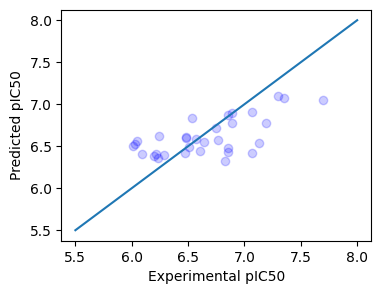

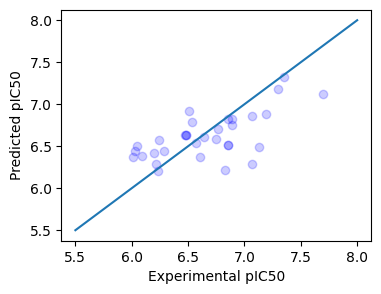

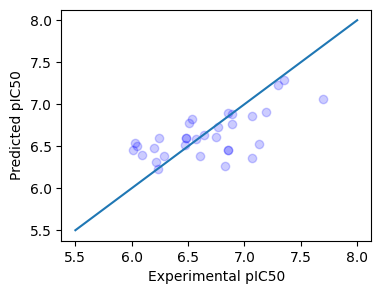

In [82]:
for Xtype in ["Xfp", "Xosmall", "Xsmall","Xofull","Xfull","Xrdkit","Xfprdkit"]:
    plt.figure(figsize=[4,3])
    plt.plot(y_test_all[Xtype], y_pred_all[Xtype], 'bo' ,alpha=.2)
    plt.plot([5.5,8],[5.5,8])
    plt.ylabel("Predicted pIC50")
    plt.xlabel("Experimental pIC50")
    plt.show()